In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

# debug for sept 16.. 
DEBURG= True

/scratch/1/mautner/oldthings/examples/Abstract


In [3]:
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools
from eden.util import random_bipartition_iter,selection_iterator
import random

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)

    
    
RFAM="RF01725"
#cutoff 162 (44.0)
#cutoff 1725 (38.0)
#cutoff rest (29)


def get_sequences(size=9999,rand=False):
    sequences = get_sequences_with_names(size=size,rand=rand)
    return [ b for (a,b) in sequences ]

def get_sequences_with_names(size=9999, rand=0):
    it = fasta_to_sequence("../toolsdata/%s.fa" % RFAM)
    it = list(it)
    if rand>0:
        #sequences , boring = random_bipartition_iter(it,.9,random_state=random.random())
        r=range(len(it))
        random.shuffle(r)
        return selection_iterator(it,r[:size])
        #sequences = itertools.islice( sequences , size)
    else:
        sequences = itertools.islice(it, size)
    return sequences




In [4]:
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    
    graphs are pretty mich (NAME,SEQUENCE),()...
    '''
    
    # fit a sampler
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1) # with .5 it also works for the fewer ones.. 
    sampler=rna.AbstractSampler(radius_list=[0], # war 0,1
                                thickness_list=[2], # war 2 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
        
    #logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    #logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    graphs = [ b for a ,b in graphs  ]
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.9,
                            improving_linear_start=0.3,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=10,
                            monitor=False)
    
    result=[]
    for graphlist in graphs:
        result+=graphlist
    
    #print 'one round done:) '
    #draw.graphlearn(result)
    
    # note that this is a list [('',sequ),..]
    r2=[]
    for r in result:
        r2.append(rna.get_sequence(r))
    #print 'grgen result is rabun not was is documentedOo.',r2
    return r2

In [7]:
import numpy as np
def eval(repeats,size):
    means=[]
    stds=[]
    for i in range(repeats):
        
        graphs=get_sequences_with_names(size=size, rand=10)
        zz=fit_sample(graphs)
        #print zz[:3]
        # z=[b for a ,b in zz]
        result=rna.infernal_checker(zz,cmfile='../%s.cm' % RFAM, cmsearchbinarypath='../toolsdata/cmsearch')
        
        a = np.array(result)
        means.append( np.mean(a, axis=0) )
        stds.append( np.std(a, axis=0) )
    
    means.sort()
    stds.sort()
    print 'eval::', (size,means,stds)
    
    return [means[2]*100,stds[2]*100]
    


eval:: (5, [0.60736363636363644, 0.61599999999999999, 0.62136363636363634, 0.63627272727272721, 0.63823076923076927], [0.073887808764529411, 0.081601126227846238, 0.097650836916092137, 0.10699532700076206, 0.10754387918618719])
eval:: (10, [0.5056250000000001, 0.54435999999999996, 0.590608695652174, 0.59647826086956512, 0.62942857142857134], [0.10992002592020562, 0.11043833505780561, 0.12921760870717272, 0.1508255166871042, 0.17355494146907294])
eval:: (15, [0.55478378378378368, 0.55882857142857145, 0.59124324324324318, 0.60992105263157881, 0.61482352941176477], [0.080276620958883022, 0.10407420163694162, 0.10566185572429646, 0.11751834943678471, 0.12130999716721622])
eval:: (20, [0.5702978723404255, 0.57297826086956527, 0.59356521739130441, 0.59672727272727277, 0.59702631578947363], [0.10172363789263221, 0.10573215809865201, 0.11006177162293376, 0.12079680346984292, 0.13886206624004155])
eval:: (25, [0.51031147540983612, 0.54471929824561394, 0.54547540983606546, 0.54988524590163934, 0

/scratch/1/martners/.local/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


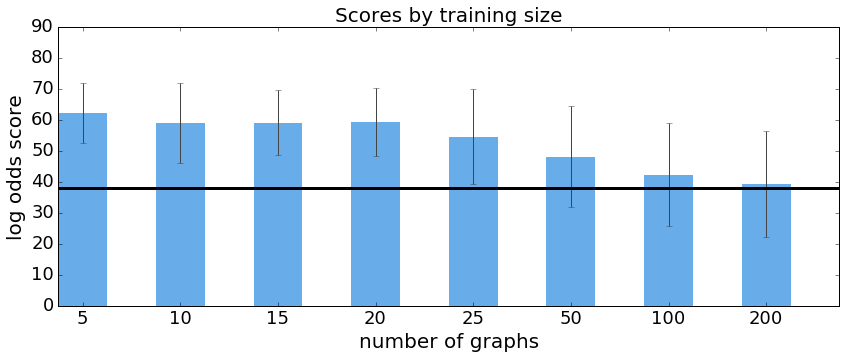

CPU times: user 6min, sys: 2min 7s, total: 8min 8s
Wall time: 1h 43min 39s


In [8]:
%%time
import numpy as np
import matplotlib.pyplot as plt


def make_bar_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=(20, 35, 30, 35, 27),stds=(2, 3, 4, 1, 2)):
    N = len(labels)
    ind = np.arange(N) 
    width = .5 #0.35
    plt.figure(figsize=(14, 5))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(18)
        
    p1 = plt.bar(ind, means, width, color='#69ACEA', yerr=stds,edgecolor='None',ecolor='#444444')
    plt.axhline(y=38, color='black',linewidth=3)
    plt.ylabel("log odds score",fontsize=20)
    plt.xlabel("number of graphs",fontsize=20)
    #plt.xlabel("number of graphs",fontsize=20)
    plt.title('Scores by training size',fontsize=20)
    plt.xticks(ind + width/2, labels )
    plt.yticks(np.arange(0, 100, 10))
    plt.show()
    
sizes=[5,10,15,20,25,50,100,200]
#sizes=[5,10] # debug so we can see the drawn graphs oOo 
#sizes=[5,10,15,20,25]

repeats=5
means=[]
stds=[]
for size in sizes:
    m,s=eval(repeats,size)
    means.append(m)
    stds.append(s)
    
    
print 'size: ' + str(sizes)
print 'means: ' + str(means)
print 'stds: ' + str(stds)

make_bar_plot(sizes,means,stds)



In [ ]:
size= [5, 10, 15, 20, 25, 30]
means= [55.87916666666667, 53.004999999999988, 48.495959595959597, 48.561904761904763, 50.952601156069363, 53.893212669683251]
stds= [6.5170276434549148, 6.2872735214346536, 11.881935352270657, 12.467295993428371, 11.861150294030125, 11.309868317224636]
size+=[50, 100, 200, 400]
means+= [m*100 for m in [0.52533233532934065, 0.52810851648351664, 0.50501132578281116, 0.48380166112956]]
stds+= [s*100 for s in [0.13776390146638864, 0.1357588381110848, 0.14529570300173117, 0.1549776798758424]]



def make_bar_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=(20, 35, 30, 35, 27),stds=(2, 3, 4, 1, 2)):
    N = len(labels)
    ind = np.arange(N) 
    width = .5 #0.35
    plt.figure(figsize=(14, 5))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(18)
    
    p1 = plt.bar(ind, means, width, color='#FF7B7B', yerr=stds)
    plt.axhline(y=38, color='black',linewidth=3)
    plt.ylabel("log odds score",fontsize=20)
    plt.xlabel("number of graphs",fontsize=20)
    #plt.xlabel("number of graphs",fontsize=20)
    plt.title('Scores by training size',fontsize=20)
    plt.xticks(ind + width/2, labels )
    plt.yticks(np.arange(0, 100, 10))
    plt.show()
    
make_bar_plot(size,means,stds)


In [ ]:
import eden
print eden.__file__
print eden.__version__

In [ ]:
!echo $PYTHONPATH

In [ ]:
size= [5, 10, 15, 20, 25, 30]
means= [55.87916666666667, 53.004999999999988, 48.495959595959597, 48.561904761904763, 50.952601156069363, 53.893212669683251]
stds= [6.5170276434549148, 6.2872735214346536, 11.881935352270657, 12.467295993428371, 11.861150294030125, 11.309868317224636]
size+=[50, 100, 200, 400]
means+= [m*100 for m in [0.52533233532934065, 0.52810851648351664, 0.50501132578281116, 0.48380166112956]]
stds+= [s*100 for s in [0.13776390146638864, 0.1357588381110848, 0.14529570300173117, 0.1549776798758424]]



def make_bar_plot(labels=('G1', 'G2', 'G3', 'G4', 'G5'),means=(20, 35, 30, 35, 27),stds=(2, 3, 4, 1, 2)):
    N = len(labels)
    ind = np.arange(N) 
    width = .5 #0.35
    plt.figure(figsize=(14, 5))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(18)
    
    p1 = plt.bar(ind, means, width, color='#69ACEA', yerr=stds,edgecolor='None',ecolor='#444444')
    plt.axhline(y=38, color='black',linewidth=3)
    #ax.yaxis.grid(color='gray', linestyle='dashed')
    plt.ylabel("log odds score",fontsize=20)
    plt.xlabel("number of graphs",fontsize=20)
    #plt.xlabel("number of graphs",fontsize=20)
    plt.title('Scores by training size',fontsize=20)
    plt.xticks(ind + width/2, labels )
    plt.yticks(np.arange(0, 100, 10))
    plt.show()
    
make_bar_plot(size,means,stds)